In [131]:
from itertools import chain, combinations

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

np.set_printoptions(suppress = True)

data = pd.read_csv('carmpg.csv')
data

,MODEL,VOL,HP,MPG,SP,WT
0,GM/GeoMetroXF1,89,49,65.4,96,17.5
1,GM/GeoMetro,92,55,56.0,97,20.0
2,GM/GeoMetroLSI,92,55,55.9,97,20.0
3,SuzukiSwift,92,70,49.0,105,20.0
4,DaihatsuCharade,92,53,46.5,96,20.0
...,...,...,...,...,...,...
77,Mercedes500SL,50,322,18.1,165,45.0
78,Mercedes560SEL,115,238,17.2,140,45.0
79,JaguarXJSConvert,50,263,17.0,147,45.0
80,BMW750IL,119,295,16.7,157,45.0


In [132]:
def powerset(s: list):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def regression(X: np.ndarray, Y: np.ndarray, feature_set: list[str] = None):
    # Num of samples
    n = X.shape[0]

    # Insert (1, X)
    X1 = np.insert(X, 0, 1, axis=1)

    # Num of features
    k = X1.shape[1]

    X_inv = np.linalg.inv(X1.T @ X1)

    # Fitted beta
    beta_hat: np.ndarray = X_inv @ X1.T @ Y

    # Residuals
    epsilon_hat: np.ndarray = Y - X1 @ beta_hat
    # Residuals error
    rss = (epsilon_hat.T @ epsilon_hat).squeeze()
    sigma2_hat = 1/(n-k) * rss

    se_hat = np.sqrt(np.diag( sigma2_hat * X_inv ))[:, None]

    # t-statistics
    t_scores = beta_hat / se_hat
    p_values = 2 * (1 - st.t.cdf(np.abs(t_scores), n-1))

    fit_results = np.concatenate((beta_hat, se_hat, t_scores, p_values), axis=1)
    index = ['const']+list(feature_set) if feature_set is not None else None
    fit_df = pd.DataFrame(
        fit_results, 
        index=index, 
        columns=['beta_hat', 'se_hat', 't_scores', 'p_values']
    )

    return fit_df, rss, sigma2_hat

def log_likelihood(rss: float, n: int) -> float:
    return -n/2*np.log(2*np.pi) - n/2*np.log(rss/n) - n/2

def mallow(S: tuple[str] | list[str], data: pd.DataFrame, Y: np.ndarray):
    X = data[list(S)].to_numpy()
    _, rss, sigma2_hat = regression(X, Y)

    # Increase length due to constant variate
    return rss + 2 * (len(S)+1) * sigma2_hat

def aic(S: tuple[str] | list[str], data: pd.DataFrame, Y: np.ndarray):
    X = data[list(S)].to_numpy()
    _, rss, _ = regression(X, Y)

    n = X.shape[0]
    k = X.shape[1]

    return 2*(k+1) - 2*log_likelihood(rss, n)

def bic(S: tuple[str] | list[str], data: pd.DataFrame, Y: np.ndarray):
    X = data[list(S)].to_numpy()
    _, rss, _ = regression(X, Y)

    n = X.shape[0]
    k = X.shape[1]

    return (k+1)*np.log(n) - 2*log_likelihood(rss, n)

In [133]:
Y = data['MPG'].to_numpy()[:, None]
X_features = ['HP', 'VOL', 'SP', 'WT']

X = data[X_features].to_numpy()

fit_df, _, _ = regression(X, Y, X_features)
fit_df

,beta_hat,se_hat,t_scores,p_values
const,192.437753,23.531613,8.177839,3.351097e-12
HP,0.392212,0.081412,4.817602,6.671547e-06
VOL,-0.015645,0.022825,-0.685425,4.950327e-01
SP,-1.294818,0.244773,-5.289864,1.019119e-06
WT,-1.859804,0.213363,-8.716617,2.888800e-13


In [134]:
# Forward + Mallow
S = []
score = (np.inf, [])

for _ in range(len(X_features)):
    S_new = S

    for x_feature in X_features:
        if x_feature in S:
            continue

        S_new = S + [x_feature]
        
        if (mallow_score := mallow(S_new, data, Y)) < score[0]:
            score = (mallow_score, S_new)
            print(score)

    S = score[1]

(3201.906866727991, ['HP'])
(1539.3017094548557, ['WT'])
(1539.2766321004597, ['WT', 'HP'])
(1488.0603689887757, ['WT', 'SP'])
(1139.6653167187014, ['WT', 'SP', 'HP'])


In [135]:
# Backward + Mallow
S = X_features.copy()
score = (mallow(S, data, Y), S)
print(score)

for _ in range(len(X_features)-1):
    for x_feature in S:
        S_new = S.copy()
        S_new.remove(x_feature)

        if (mallow_score := mallow(S_new, data, Y)) < score[0]:
            score = (mallow_score, S_new)
            print(score)

    S = score[1]

(1160.8076431321144, ['HP', 'VOL', 'SP', 'WT'])
(1139.6653167187017, ['HP', 'SP', 'WT'])


In [136]:
# Zheng-Loh
W = fit_df.loc[fit_df.index != 'const', 't_scores'].abs().sort_values(ascending=False)

for j in range(len(W)):
    S = W.index[:j+1].to_list()
    _, rss, sigma2_hat = regression(data[S].to_numpy(), Y)
    out = rss + (j+1) * sigma2_hat * np.log(len(Y))
    print(out, S)

1546.7548479379752 ['WT']
1537.3140904510738 ['WT', 'SP']
1208.8424414410483 ['WT', 'SP', 'HP']
1262.5701385588486 ['WT', 'SP', 'HP', 'VOL']


In [137]:
# All + Mallow
mallow_results = []
for S in powerset(X_features):
    if not S:
        continue

    mallow_score = mallow(S, data, Y)
    mallow_results.append((S, mallow_score))

mallow_df = pd.DataFrame(mallow_results, columns=['S', 'Score'])
mallow_df

,S,Score
0,"(HP,)",3201.906867
1,"(VOL,)",7356.145215
2,"(SP,)",4478.107350
3,"(WT,)",1539.301709
4,"(HP, VOL)",2447.534631
5,"(HP, SP)",2535.499584
6,"(HP, WT)",1539.276632
7,"(VOL, SP)",3202.609727
8,"(VOL, WT)",1573.165939
9,"(SP, WT)",1488.060369


In [138]:
# All + BIC
bic_results = []
for S in powerset(X_features):
    if not S:
        continue

    bic_score = bic(S, data, Y)
    bic_results.append((S, bic_score))

bic_df = pd.DataFrame(bic_results, columns=['S', 'Score'])
bic_df

,S,Score
0,"(HP,)",538.030734
1,"(VOL,)",606.237475
2,"(SP,)",565.537959
3,"(WT,)",477.972487
4,"(HP, VOL)",518.405015
5,"(HP, SP)",521.300389
6,"(HP, WT)",480.375985
7,"(VOL, SP)",540.453566
8,"(VOL, WT)",482.161742
9,"(SP, WT)",477.601180


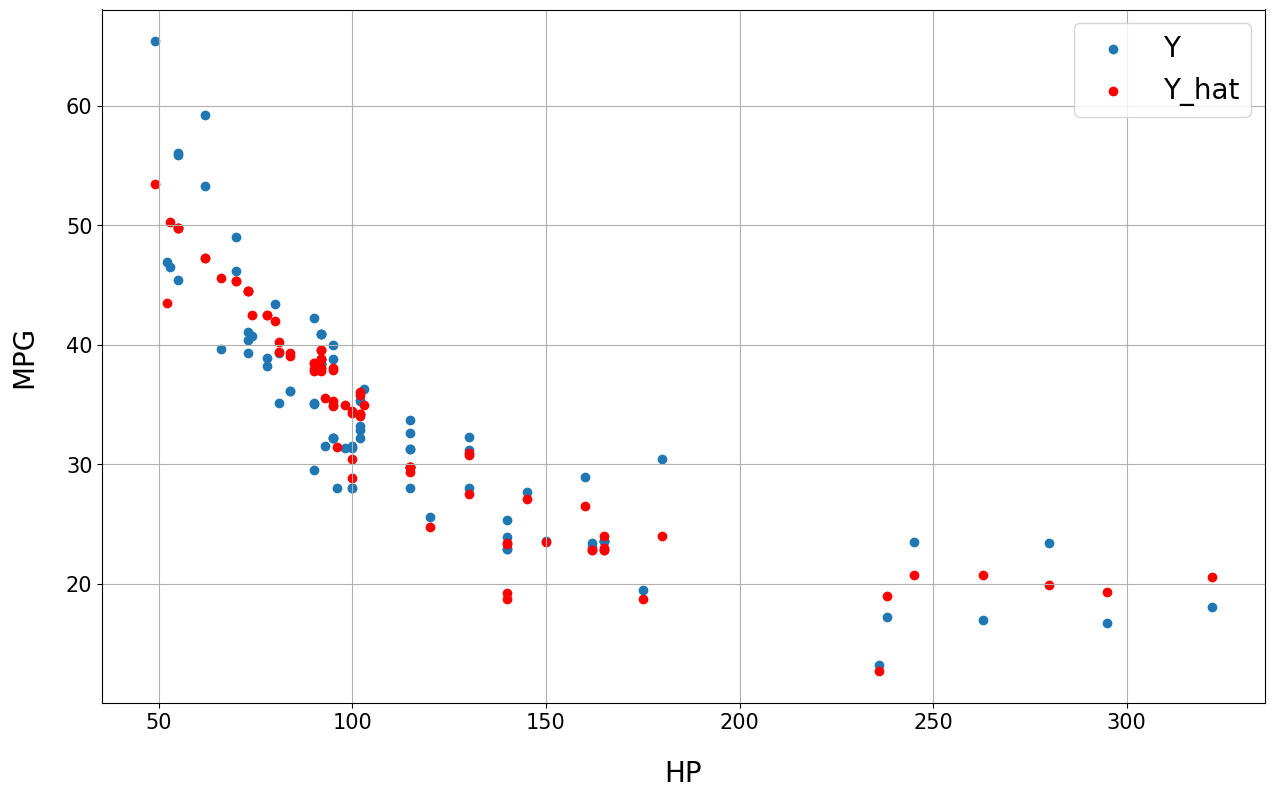

In [139]:
X_HP = data['HP'].to_numpy()

# Predictions
X1 = np.insert(X, 0, 1, axis=1)
Y_hat = X1 @ fit_df['beta_hat'].to_numpy()

#  Plot
font_size = 20
label_pad = 20

plt.figure(figsize=(15, 9))
plt.grid()

plt.scatter(X_HP, Y.squeeze())
plt.scatter(X_HP, Y_hat, color='r')

plt.legend(['Y', 'Y_hat'], fontsize=font_size)

plt.xlabel('HP', fontsize=font_size, labelpad=label_pad)
plt.ylabel('MPG', fontsize=font_size, labelpad=label_pad)

plt.xticks(fontsize=0.75*font_size)
plt.yticks(fontsize=0.75*font_size)

plt.show()

In [140]:
fit_df

,beta_hat,se_hat,t_scores,p_values
const,192.437753,23.531613,8.177839,3.351097e-12
HP,0.392212,0.081412,4.817602,6.671547e-06
VOL,-0.015645,0.022825,-0.685425,4.950327e-01
SP,-1.294818,0.244773,-5.289864,1.019119e-06
WT,-1.859804,0.213363,-8.716617,2.888800e-13


In [141]:
import re
import array_to_latex as a2l

def multireplace(string: str, replacements: dict) -> str:
    """
    Given a string and a replacement map, it returns the replaced string.

    :param str string: string to execute replacements on
    :param dict replacements: replacement dictionary {value to find: value to replace}
    :rtype: str

    """
    if not replacements:
        return string
        
    # Place longer ones first to keep shorter substrings from matching
    # where the longer ones should take place
    # For instance given the replacements {'ab': 'AB', 'abc': 'ABC'} against 
    # the string 'hey abc', it should produce 'hey ABC' and not 'hey ABc'
    substrs = sorted(replacements, key=len, reverse=True)

    # Create a big OR regex that matches any of the substrings to replace
    regexp = re.compile('|'.join(map(re.escape, substrs)))

    # For each match, look up the new string in the replacements
    return regexp.sub(lambda match: replacements[match.group(0)], string)

def df2latex(
        df: pd.DataFrame, 
        tex: str, 
        keep_index: bool = True, 
        keep_headers: bool = False,
        align_format: str = None,
    ):
    tabular_replacements = {
        'tabular': 'array',
        '\\toprule\n': '',
        '\\midrule\n': '',
        '\\bottomrule\n': ''
    }
    new_tex = multireplace(tex, tabular_replacements)
    # print(new_tex)
    num_columns = df.shape[1] + 1 if keep_index else df.shape[1]
    align_format = '|c'*num_columns + '|' if not align_format else align_format
    if keep_headers:
        headers = [f'\\text{{{item}}}' for item in fit_df.columns]
        headers_str = ' & '.join(headers) + '\\\\'

    align_str = '\\begin{array}' + f'{{{align_format}}} \n\\hline'

    text_replacements = {
        # '\\begin{array}': align_str + f'\n {headers_str}' if keep_headers else align_str,
        '\\\\': '\\\\ \n\\hline',
        # '\n\\end{array}': '\\\\ \n\\hline \n\\end{array}'
    }
    return multireplace(new_tex, text_replacements)

# tex = a2l.to_ltx(mallow_df.to_numpy(), frmt = '{:6.3f}', arraytype='array', print_out=False)
# print(df2latex(mallow_df, tex))

In [142]:
import pyperclip

tex = mallow_df.to_latex(index=False)
pyperclip.copy(df2latex(mallow_df, tex, keep_index=False, align_format='|l|r|'))

In [143]:
# %reset -f